# Building an Denoising Autoencoder in Keras for MNIST 

## Importing the MNIST dataset 

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


## Adding noise to the input 

In [3]:

#input keras CNN accept only 4d tensors
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
x_train /= 255
x_test /= 255

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)



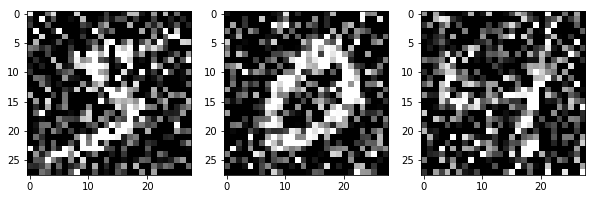

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(x_train_noisy[i].reshape((28,28)), cmap='gray')

## Defining the model 

In [8]:
import keras

input_layer = keras.layers.Input((28, 28, 1))
conv_1 = keras.layers.convolutional.Conv2D(10, (5, 5), strides=(1,1), activation='relu', 
                                            kernel_initializer='glorot_normal')(input_layer)

pool_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = keras.layers.convolutional.Conv2D(20, (2, 2), strides=(1, 1), activation='relu',
                                            kernel_initializer='glorot_normal')(pool_1)

pool_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

#encoding

up_1 = keras.layers.UpSampling2D(size=(2,2))(pool_2)

convt_1 = keras.layers.Conv2DTranspose(20, (2, 2), strides=(1,1), activation='relu',
                                             kernel_initializer='glorot_normal')(up_1)

up_2 = keras.layers.UpSampling2D(size=(2,2))(convt_1)

convt_2 = keras.layers.Conv2DTranspose(10, (5, 5), strides=(1,1), activation='relu',
                                             kernel_initializer='glorot_normal')(up_2)

out = keras.layers.Conv2DTranspose(1, (3, 3), strides=(1,1), activation='sigmoid',
                                             kernel_initializer='glorot_normal')(convt_2)
    
model = keras.models.Model(input=input_layer, output=out)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 20)        820       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 10, 10, 20)        0         
_________________________________________________________________
con

/home/cfcv/Tensorflow/ML/local/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


## Training the model 

In [53]:
from keras.callbacks import ModelCheckpoint

epochs = 5
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.keras.hdf5',
                              verbose=1, save_best_only=True)

model.fit(x_train_noisy, x_train,
          validation_data=(x_test_noisy, x_test),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 117s - loss: 0.1037 - val_loss: 0.1031
Epoch 2/5
60000/60000 [==============================] - 105s - loss: 0.1029 - val_loss: 0.1016
Epoch 3/5
60000/60000 [==============================] - 107s - loss: 0.1024 - val_loss: 0.1010
Epoch 4/5
60000/60000 [==============================] - 2507s - loss: 0.1019 - val_loss: 0.1007
Epoch 5/5
60000/60000 [==============================] - 102s - loss: 0.1015 - val_loss: 0.1002


## Viewing the results 

In [9]:
model.load_weights('saved_models/weights.best.keras.hdf5')

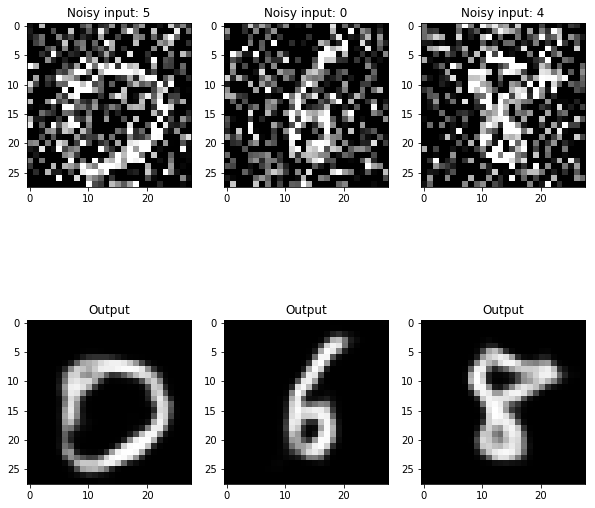

In [27]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(10,10))
random_index = []
random_index.append(random.randint(0, len(x_test_noisy)))
random_index.append(random.randint(0, len(x_test_noisy)))
random_index.append(random.randint(0, len(x_test_noisy)))

for i in range(len(random_index)):
    ax = fig.add_subplot(2, 3, i+1)
    ax2 = fig.add_subplot(2, 3, i+4)
    predict = model.predict(np.expand_dims(np.array(x_test_noisy[random_index[i]]), axis=0))
    ax2.set_title('Output')
    ax2.imshow(predict.reshape((28,28)), cmap='gray')
    ax.set_title('Noisy input: ' + str(y_train[i]))
    ax.imshow(x_test_noisy[random_index[i]].reshape((28,28)), cmap='gray')